In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTEN
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing my own functions

from decision_tree import decision_tree
from adaboost import adaboost_classifier
from knn import knn_classifier
from naive_bayes import naive_bayes
from svm import support_vector_machines
from random_forest import random_forest
from logistic_regression import logistic_regression
from xgboost import xgboost_classifier


In [3]:
data = "data/echocardiogram.data"
names = "data/echocardiogram.names"
test = "data/echocardiogram.test"

In [4]:
# Read the .data file into a DataFrame
df = pd.read_csv(data, header=None) # Assuming there's no header in the file
df.head() # Display the first few rows of the DataFrame

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,11.0,0,71,0,0.260,9,4.600,14,1,1,name,1,0
1,19.0,0,72,0,0.380,6,4.100,14,1.700,0.588,name,1,0
2,16.0,0,55,0,0.260,4,3.420,14,1,1,name,1,0
3,57.0,0,60,0,0.253,12.062,4.603,16,1.450,0.788,name,1,0
4,19.0,1,57,0,0.160,22,5.750,18,2.250,0.571,name,1,0


In [5]:
# Define column names
column_names = ["survival", "still-alive", "age-at-heart-attack", "pericardial-effusion", "fractional-shortening",
               "epss", "lvdd", "wall-motion-score", "wall-motion-index", "mult", "name", "group", "alive-at-1"] # Add all column names here

# Assign column names to the DataFrame
df.columns = column_names

# Now you can use your DataFrame with column names assigned
df.head() # Display the first few rows of the DataFrame

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,mult,name,group,alive-at-1
0,11.0,0,71,0,0.260,9,4.600,14,1,1,name,1,0
1,19.0,0,72,0,0.380,6,4.100,14,1.700,0.588,name,1,0
2,16.0,0,55,0,0.260,4,3.420,14,1,1,name,1,0
3,57.0,0,60,0,0.253,12.062,4.603,16,1.450,0.788,name,1,0
4,19.0,1,57,0,0.160,22,5.750,18,2.250,0.571,name,1,0


In [6]:
# Drop irrelevant columns
df.drop(["name", "group", "mult"], axis=1, inplace=True)

In [7]:
df.dtypes

survival                 float64
still-alive                int64
age-at-heart-attack       object
pericardial-effusion       int64
fractional-shortening     object
epss                      object
lvdd                      object
wall-motion-score         object
wall-motion-index         object
alive-at-1                object
dtype: object

In [8]:
# Convert object columns to float
df = df.apply(pd.to_numeric, errors='coerce')

# Check the data types after conversion
print(df.dtypes)

survival                 float64
still-alive                int64
age-at-heart-attack      float64
pericardial-effusion       int64
fractional-shortening    float64
epss                     float64
lvdd                     float64
wall-motion-score        float64
wall-motion-index        float64
alive-at-1               float64
dtype: object


In [9]:
# use info() to get summary of the dataframe
summary = df.info()
print(summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   survival               110 non-null    float64
 1   still-alive            110 non-null    int64  
 2   age-at-heart-attack    108 non-null    float64
 3   pericardial-effusion   110 non-null    int64  
 4   fractional-shortening  103 non-null    float64
 5   epss                   96 non-null     float64
 6   lvdd                   100 non-null    float64
 7   wall-motion-score      107 non-null    float64
 8   wall-motion-index      109 non-null    float64
 9   alive-at-1             73 non-null     float64
dtypes: float64(8), int64(2)
memory usage: 8.7 KB
None


In [10]:
# Find out the percentage of missing values in each column in the given dataset
df.isnull().sum() * 100 / len(df)

survival                  0.000000
still-alive               0.000000
age-at-heart-attack       1.818182
pericardial-effusion      0.000000
fractional-shortening     6.363636
epss                     12.727273
lvdd                      9.090909
wall-motion-score         2.727273
wall-motion-index         0.909091
alive-at-1               33.636364
dtype: float64

# Feature Engineering

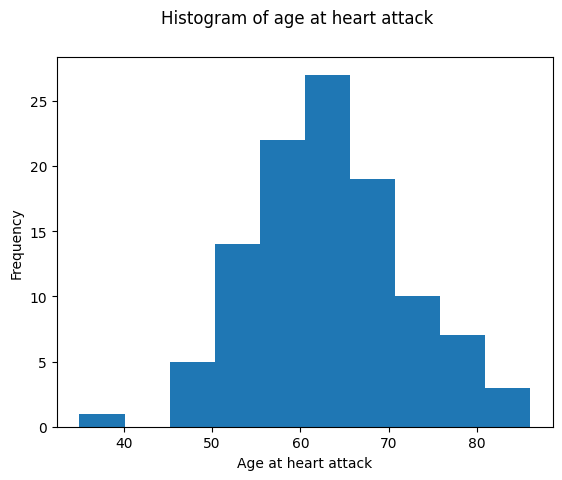

In [15]:
# 
ax = df['age-at-heart-attack'].plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Histogram of age at heart attack', xlabel="Age at heart attack")

In [11]:
# Define age groups
bins = [0, 55, 65, 100]  # Define the age boundaries for each group
labels = ['0-55', '55-65', '65-100']  # Define labels for each group

# Create a new column for age groups
df['age_group'] = pd.cut(df['age-at-heart-attack'], bins=bins, labels=labels, right=False)

# Display the first few rows to verify
df[['age-at-heart-attack', 'age_group']].head()

,age-at-heart-attack,age_group
0,71.0,65-100
1,72.0,65-100
2,55.0,55-65
3,60.0,55-65
4,57.0,55-65


# Preparation of Labelled Data

In [4]:
# Select all patients who either survived beyond a two-year period or who passed away within two years of diagnosis.
df_labelled = df[ (df["survival"] >= 24) | (df["survival"] < 24) & (df["still-alive"] == 0) ].copy()
df_labelled['target'] = df_labelled["still-alive"].astype(int) # 1 if survived at least 2 years, else 0
df_labelled.head()

NameError: name 'df' is not defined

In [373]:
# Find out the percentage of missing values in each column in the given dataset
df_labelled.isnull().sum() * 100 / len(df_labelled)

survival                  0.000000
still-alive               0.000000
age-at-heart-attack       0.000000
pericardial-effusion      0.000000
fractional-shortening     4.225352
epss                     11.267606
lvdd                      4.225352
wall-motion-score         1.408451
wall-motion-index         0.000000
alive-at-1               35.211268
target                    0.000000
dtype: float64

In [374]:
# Drop unnecessary columns
df_labelled.drop(["survival", "still-alive", "alive-at-1", "wall-motion-score"], axis=1, inplace=True)
df_labelled.dropna(inplace=True)
df_labelled.head()

,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-index,target
0,71.0,0,0.260,9.000,4.600,1.00,0
1,72.0,0,0.380,6.000,4.100,1.70,0
2,55.0,0,0.260,4.000,3.420,1.00,0
3,60.0,0,0.253,12.062,4.603,1.45,0
5,68.0,0,0.260,5.000,4.310,1.00,0


In [375]:
df_labelled.shape

(61, 7)

In [376]:
df_labelled["target"].value_counts()

target
0    60
1     1
Name: count, dtype: int64

In [377]:
df_labelled[df_labelled["target"] == 1]

,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-index,target
94,74.0,0,0.2,4.8,4.56,1.04,1


# Preparation of Unlabelled Data

In [378]:
# Unlabelled data
df_unlabelled = df[ (df["survival"] < 24) & (df["still-alive"] == 1) ]

# Drop unnecessary columns
df_unlabelled.drop(["survival", "still-alive", "alive-at-1", "wall-motion-score"], axis=1, inplace=True)
df_unlabelled.dropna(inplace=True)
df_unlabelled.head()


,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-index
4,57.000,0,0.16,22.0,5.75,2.25
10,77.000,0,0.13,16.0,4.23,1.80
14,62.000,0,0.12,23.0,5.80,2.33
16,69.000,1,0.26,11.0,4.65,1.64
17,62.529,1,0.07,20.0,5.20,2.00


In [379]:
df_unlabelled.shape

(29, 6)

In [10]:
#df_cluster = df[(df["survival"] > 12) & (df["survival"] < 24) & (df["still-alive"] == 1)]
df_cluster = df[(df["survival"] < 24) & (df["still-alive"] == 1)]
df_cluster.head()

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1
4,19.0,1,57.000,0,0.16,22.0,5.75,18.00,2.25,0.0
10,10.0,1,77.000,0,0.13,16.0,4.23,18.00,1.80,1.0
14,0.5,1,62.000,0,0.12,23.0,5.80,11.67,2.33,1.0
16,0.5,1,69.000,1,0.26,11.0,4.65,18.00,1.64,1.0
17,0.5,1,62.529,1,0.07,20.0,5.20,24.00,2.00,1.0


In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)

X = df_cluster.drop(["survival", "still-alive", "alive-at-1"], axis=1)

# Handle missing values
X.dropna(inplace=True)

y_kmeans = kmeans.fit_predict(X)

In [12]:
y_kmeans

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0], dtype=int32)

In [13]:
X[y_kmeans == 0]

,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index
16,69.0,1,0.260,11.000,4.650,18.00,1.640
18,66.0,0,0.090,17.000,5.819,8.00,1.333
22,73.0,0,0.230,12.733,6.060,7.50,1.500
23,71.0,0,0.170,0.000,4.650,8.00,1.000
31,52.0,1,0.170,17.200,5.320,14.00,1.170
44,67.0,1,0.440,9.000,3.960,17.50,1.450
62,59.0,0,0.130,16.400,4.960,17.83,1.370
65,50.0,0,0.140,11.400,4.750,10.00,2.500
88,60.0,0,0.180,8.700,4.560,13.50,1.040
89,67.0,0,0.155,11.300,5.160,13.00,1.000


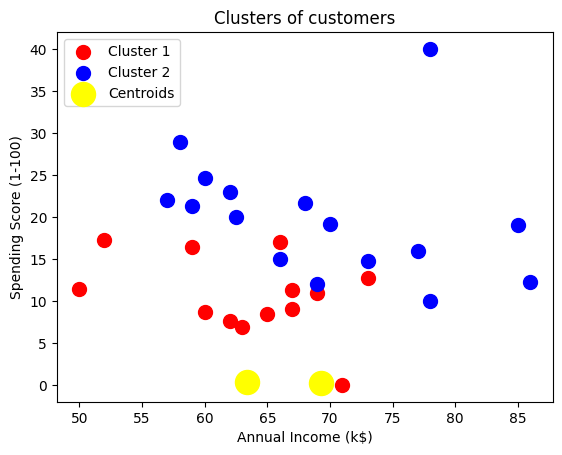

In [14]:
plt.scatter(X[y_kmeans == 0]["age-at-heart-attack"], X[y_kmeans == 0]["epss"], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1]["age-at-heart-attack"], X[y_kmeans == 1]["epss"], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

In [15]:
X["survival-boolean"] = np.where(y_kmeans == 0, 0, 1)
X.head()

,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,survival-boolean
4,57.000,0,0.16,22.0,5.75,18.00,2.25,1
10,77.000,0,0.13,16.0,4.23,18.00,1.80,1
14,62.000,0,0.12,23.0,5.80,11.67,2.33,1
16,69.000,1,0.26,11.0,4.65,18.00,1.64,0
17,62.529,1,0.07,20.0,5.20,24.00,2.00,1


In [16]:
frames = [df, X[["survival-boolean"]]]
df = pd.concat(frames, axis=1 )
df.head()

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1,survival-boolean
0,11.0,0,71.0,0,0.260,9.000,4.600,14.0,1.00,0.0,NaN
1,19.0,0,72.0,0,0.380,6.000,4.100,14.0,1.70,0.0,NaN
2,16.0,0,55.0,0,0.260,4.000,3.420,14.0,1.00,0.0,NaN
3,57.0,0,60.0,0,0.253,12.062,4.603,16.0,1.45,0.0,NaN
4,19.0,1,57.0,0,0.160,22.000,5.750,18.0,2.25,0.0,1.0


In [17]:
df

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1,survival-boolean
0,11.00,0,71.0,0,0.260,9.000,4.600,14.0,1.00,0.0,NaN
1,19.00,0,72.0,0,0.380,6.000,4.100,14.0,1.70,0.0,NaN
2,16.00,0,55.0,0,0.260,4.000,3.420,14.0,1.00,0.0,NaN
3,57.00,0,60.0,0,0.253,12.062,4.603,16.0,1.45,0.0,NaN
4,19.00,1,57.0,0,0.160,22.000,5.750,18.0,2.25,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
105,24.00,0,57.0,0,0.036,7.000,4.120,13.5,1.23,NaN,NaN
106,0.75,1,78.0,0,0.230,40.000,6.230,14.0,1.40,1.0,1.0
107,3.00,1,62.0,0,0.260,7.600,4.420,14.0,1.00,1.0,0.0
108,27.00,0,62.0,0,0.220,12.100,3.920,11.0,1.00,NaN,NaN


In [18]:
# Some patients have survived less than one year but they are still alive.
# Let's remove such patients as they cannot be used for the prediction task.
#df = df[~((df["survival"] < 12) & (df["still-alive"] == 1))]
#df.head()

In [19]:
# Some patients have survived between 12 and 24 months, and they are still alive.
# So we have to take a decision how to label those 5 patients.

#df[((df["survival"] > 12) & (df["survival"] < 24) & (df["still-alive"] == 1))]

In [20]:
# Drop unnecessary columns
df.drop(["alive-at-1", "wall-motion-score"], axis=1, inplace=True)
df.head()

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-index,survival-boolean
0,11.0,0,71.0,0,0.260,9.000,4.600,1.00,NaN
1,19.0,0,72.0,0,0.380,6.000,4.100,1.70,NaN
2,16.0,0,55.0,0,0.260,4.000,3.420,1.00,NaN
3,57.0,0,60.0,0,0.253,12.062,4.603,1.45,NaN
4,19.0,1,57.0,0,0.160,22.000,5.750,2.25,1.0


In [21]:
# use info() to get summary of the dataframe
summary = df.info()
print(summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   survival               110 non-null    float64
 1   still-alive            110 non-null    int64  
 2   age-at-heart-attack    108 non-null    float64
 3   pericardial-effusion   110 non-null    int64  
 4   fractional-shortening  103 non-null    float64
 5   epss                   96 non-null     float64
 6   lvdd                   100 non-null    float64
 7   wall-motion-index      109 non-null    float64
 8   survival-boolean       29 non-null     float64
dtypes: float64(7), int64(2)
memory usage: 7.9 KB
None


In [22]:
# Find out the percentage of missing values in each column in the given dataset
df.isnull().sum() * 100 / len(df)

survival                  0.000000
still-alive               0.000000
age-at-heart-attack       1.818182
pericardial-effusion      0.000000
fractional-shortening     6.363636
epss                     12.727273
lvdd                      9.090909
wall-motion-index         0.909091
survival-boolean         73.636364
dtype: float64

In [23]:
# Handle missing values
subset = ['survival', 'still-alive', 'age-at-heart-attack', 'pericardial-effusion', 'fractional-shortening', 'epss', 'lvdd', 'wall-motion-index']
df.dropna(subset = subset, inplace=True)

# Find out the percentage of missing values in each column in the given dataset
df.isnull().sum() * 100 / len(df)

survival                  0.000000
still-alive               0.000000
age-at-heart-attack       0.000000
pericardial-effusion      0.000000
fractional-shortening     0.000000
epss                      0.000000
lvdd                      0.000000
wall-motion-index         0.000000
survival-boolean         67.777778
dtype: float64

In [24]:
# use info() to get summary of the dataframe
summary = df.info()
print(summary)

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 0 to 109
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   survival               90 non-null     float64
 1   still-alive            90 non-null     int64  
 2   age-at-heart-attack    90 non-null     float64
 3   pericardial-effusion   90 non-null     int64  
 4   fractional-shortening  90 non-null     float64
 5   epss                   90 non-null     float64
 6   lvdd                   90 non-null     float64
 7   wall-motion-index      90 non-null     float64
 8   survival-boolean       29 non-null     float64
dtypes: float64(7), int64(2)
memory usage: 7.0 KB
None


<Axes: >

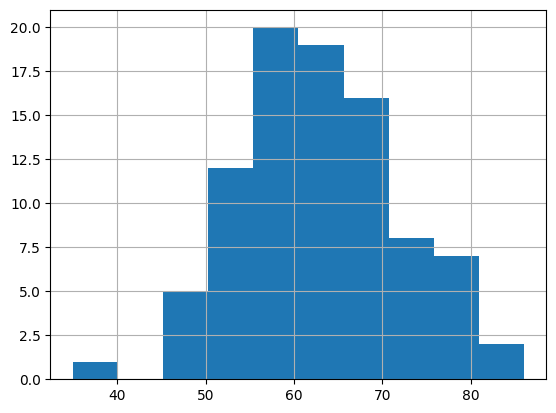

In [25]:
df['age-at-heart-attack'].hist()

In [26]:
# Define age groups
bins = [0, 55, 65, 100]  # Define the age boundaries for each group
labels = ['0-55', '55-65', '65-100']  # Define labels for each group

# Create a new column for age groups
df['age_group'] = pd.cut(df['age-at-heart-attack'], bins=bins, labels=labels, right=False)

# Display the first few rows to verify
df[['age-at-heart-attack', 'age_group']].head()

,age-at-heart-attack,age_group
0,71.0,65-100
1,72.0,65-100
2,55.0,55-65
3,60.0,55-65
4,57.0,55-65


<Axes: >

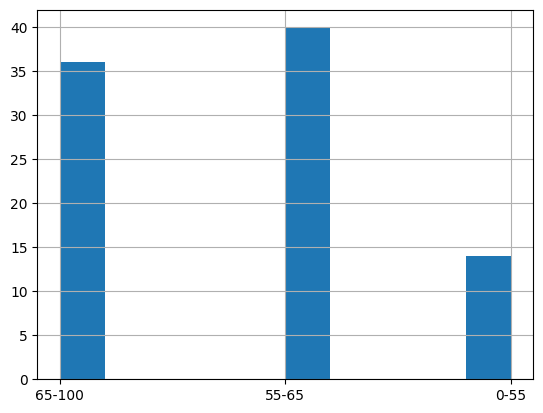

In [27]:
df['age_group'].hist()

<Axes: >

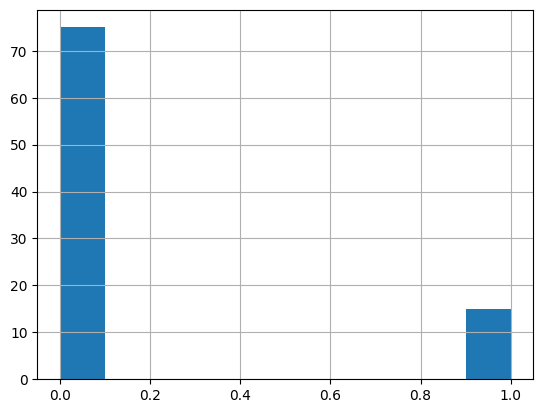

In [28]:
df['pericardial-effusion'].hist()

<Axes: >

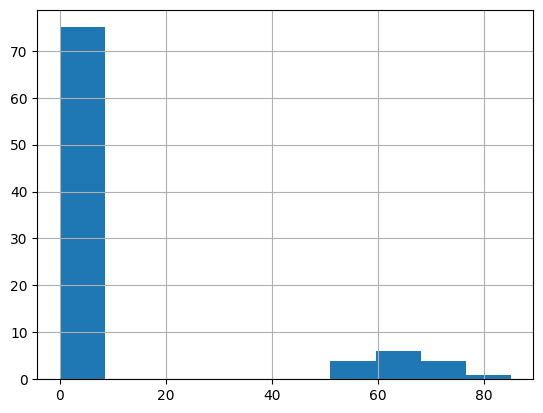

In [29]:
# Multiply age-at-heart-attack by pericardial-effusion and create a new feature
df['age_pericardial_interaction'] = df['age-at-heart-attack'] * df['pericardial-effusion']
df['age_pericardial_interaction'].hist()

In [30]:
df.columns.tolist()

['survival',
 'still-alive',
 'age-at-heart-attack',
 'pericardial-effusion',
 'fractional-shortening',
 'epss',
 'lvdd',
 'wall-motion-index',
 'survival-boolean',
 'age_group',
 'age_pericardial_interaction']

In [31]:
# Change the order of DataFrame columns to prepare it for Label Encoding for the 'age_group' column

df = df[['age_group', 
     'pericardial-effusion',
     'survival',
     'age-at-heart-attack',
     'fractional-shortening',
     'epss',
     'lvdd',
     'wall-motion-index',
     'still-alive',
     'age_pericardial_interaction', 
     'survival-boolean']]

In [32]:
df.describe()

,pericardial-effusion,survival,age-at-heart-attack,fractional-shortening,epss,lvdd,wall-motion-index,still-alive,age_pericardial_interaction,survival-boolean
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,29.000000
mean,0.166667,22.316667,63.050322,0.219167,12.320867,4.770800,1.371267,0.333333,10.772544,0.551724
std,0.374766,16.666246,9.059723,0.109469,7.127509,0.794541,0.439698,0.474045,24.454632,0.506120
min,0.000000,0.250000,35.000000,0.010000,0.000000,3.100000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,6.250000,57.000000,0.150000,7.200000,4.240000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,23.500000,62.000000,0.220000,11.150000,4.601500,1.206000,0.000000,0.000000,1.000000
75%,0.000000,33.000000,69.000000,0.271500,16.075000,5.315000,1.507500,1.000000,0.000000,1.000000
max,1.000000,57.000000,86.000000,0.610000,40.000000,6.740000,3.000000,1.000000,85.000000,1.000000


In [227]:
# Define features and target variable
X = df.drop(["survival", "still-alive", "survival-boolean"], axis=1)
#y = (df["survival"] >= 24).astype(int) # 1 if survived at least 2 years, else 0
y = ((df["survival"] > 24) | ((df["survival"] <= 24) & (df["still-alive"] == 1) & (df["survival-boolean"] == 1))).astype(int) # 1 if survived at least 2 years, else 0

In [228]:
y.value_counts() # Imbalanced target

1    58
0    32
Name: count, dtype: int64

In [255]:
# Encoding categorical data -> age_group
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0, 1])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

# Encoding the Dependent Variable (y)
le = LabelEncoder()
y = le.fit_transform(y)

# Oversampling 

# set up SMOTE
#sampler = SMOTEN(
#    sampling_strategy = 'auto', # samples only the minority class
#    random_state = 42, # for reproducibility
#    k_neighbors = 10,
#    n_jobs = 4
#)

# set up ADASYN
sampler = ADASYN(
    sampling_strategy = 'auto', # samples only the minority class
    random_state = 42, # for reproducibility
    n_neighbors = 5,
    n_jobs = 4
)

#################################################################

# Combination of over and under sampling methods

# set up SMOTE
#sm = SMOTE(
#    sampling_strategy = 'auto', # samples only the minority class
#    random_state = 42, # for reproducibility
#    k_neighbors = 5,
#    n_jobs = 4
#)

# need ENN as argument of SMOTEENN
#enn = EditedNearestNeighbours(
#    sampling_strategy = 'all',
#    n_neighbors = 3,
#    kind_sel='all',
#    n_jobs = 4    
#    )

# set up SMOTEENN
#sme = SMOTEENN(
#    sampling_strategy = 'all', # samples only the minority class
#    random_state = 42, # for reproducibility
#    smote=sm,
#    enn=enn,
#    n_jobs = 4)


X_res, y_res = sampler.fit_resample(X, y)


In [256]:
y_res = pd.Series(y_res)
y_res.value_counts()

0    62
1    58
Name: count, dtype: int64

In [257]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.35, random_state=42)

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [258]:
# Convert the scaled numpy array back into a DataFrame
X_train_df = pd.DataFrame(X_train, columns=ct.get_feature_names_out())
X_train_df.describe()

,encoder__x0_0.0,encoder__x0_1.0,encoder__x1_0.0,encoder__x1_1.0,remainder__x2,remainder__x3,remainder__x4,remainder__x5,remainder__x6,remainder__x7,remainder__x8,remainder__x9,remainder__x10
count,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01
mean,1.693802e-16,1.095989e-16,9.109522e-17,-9.109522e-17,1.010588e-16,2.704389e-17,7.116814e-17,1.214129e-15,-1.281027e-16,2.691935e-16,-4.198920e-17,-8.061571e-16,-3.273735e-17
std,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00,1.006473e+00
min,-2.406076e+00,-4.392663e-01,-1.060185e+00,-1.004332e+00,-7.644042e-01,-2.138090e+00,-4.677072e-01,-2.095806e+00,-2.233098e+00,-1.661458e+00,-2.366117e+00,-9.071043e-01,-4.634616e-01
25%,4.392663e-01,-4.392663e-01,-1.060185e+00,-1.004332e+00,-7.644042e-01,4.677072e-01,-4.677072e-01,-6.680222e-01,-6.184210e-01,-6.293996e-01,-6.752794e-01,-8.293360e-01,-4.634616e-01
50%,4.392663e-01,-4.392663e-01,7.244774e-02,-7.244774e-02,-7.644042e-01,4.677072e-01,-4.677072e-01,-1.902960e-02,-4.634597e-02,-2.131718e-01,-8.379539e-02,-2.062189e-01,-4.634616e-01
75%,4.392663e-01,-4.392663e-01,1.004332e+00,1.060185e+00,1.363989e+00,4.677072e-01,-4.677072e-01,7.273119e-01,4.463931e-01,5.191263e-01,6.989512e-01,3.137726e-01,-4.634616e-01
max,4.392663e-01,2.406076e+00,1.004332e+00,1.060185e+00,1.363989e+00,4.677072e-01,2.138090e+00,2.966336e+00,3.018704e+00,3.681474e+00,2.701056e+00,3.976403e+00,2.907149e+00


In [259]:
# Convert the scaled numpy array back into a DataFrame
X_test_df = pd.DataFrame(X_test, columns=ct.get_feature_names_out())
X_test_df.describe()

,encoder__x0_0.0,encoder__x0_1.0,encoder__x1_0.0,encoder__x1_1.0,remainder__x2,remainder__x3,remainder__x4,remainder__x5,remainder__x6,remainder__x7,remainder__x8,remainder__x9,remainder__x10
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.176549,-0.176549,0.162695,-0.162695,0.299792,0.095450,-0.095450,0.335408,0.030519,-0.205391,-0.151161,-0.094734,-0.097307
std,0.820909,0.820909,1.021364,1.021364,1.077096,0.922892,0.922892,1.187926,1.180086,0.675587,1.039440,0.962757,0.910963
min,-2.406076,-0.439266,-1.060185,-1.004332,-0.764404,-2.138090,-0.467707,-3.523590,-2.018739,-1.661458,-1.835669,-0.907104,-0.463462
25%,0.439266,-0.439266,-1.060185,-1.004332,-0.764404,0.467707,-0.467707,-0.375976,-0.800522,-0.694218,-0.697998,-0.906265,-0.463462
50%,0.439266,-0.439266,1.004332,-1.004332,0.299792,0.467707,-0.467707,0.305467,-0.089505,-0.292332,-0.350053,-0.516424,-0.463462
75%,0.439266,-0.439266,1.004332,1.060185,1.363989,0.467707,-0.467707,1.069987,0.615036,0.085013,0.219816,0.291646,-0.463462
max,0.439266,2.406076,1.004332,1.060185,1.363989,0.467707,2.138090,3.096135,4.197680,1.490872,2.715015,2.308545,2.312335


In [323]:
knn_best_params, knn_best_estimator = knn_classifier(X_train, y_train, X_test, y_test)
nb_best_params, nb_best_estimator = naive_bayes(X_train, y_train, X_test, y_test)
dt_best_params, dt_best_estimator = decision_tree(X_train, y_train, X_test, y_test)
lr_best_params, lr_best_estimator = logistic_regression(X_train, y_train, X_test, y_test)
rf_best_params, rf_best_estimator = random_forest(X_train, y_train, X_test, y_test)
svm_best_params, svm_best_estimator = support_vector_machines(X_train, y_train, X_test, y_test)
xgboost_best_params, xgboost_best_estimator = xgboost_classifier(X_train, y_train, X_test, y_test)
adaboost_best_params, adaboost_best_estimator = adaboost_classifier(X_train, y_train, X_test, y_test)




============================= KNN Classifier ==================================
Best Parameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
F1 Macro Score: 72.52 %
Accuracy: 76.19 %
Standard Deviation of Cross Validation Scores: 12.99 %
Confusion Matrix:
 [[20  1]
 [ 9 12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.95      0.80        21
           1       0.92      0.57      0.71        21

    accuracy                           0.76        42
   macro avg       0.81      0.76      0.75        42
weighted avg       0.81      0.76      0.75        42



============================= Naive Bayes Classifier ==================================
Best Parameters: {'priors': None}
F1 Macro Score: 45.07 %
Accuracy: 64.29 %
Standard Deviation of Cross Validation Scores: 0.00 %
Confusion Matrix:
 [[15  6]
 [ 9 12]]
Classification Report:
               precisio

In [342]:
def stack_model1(X_train, y_train, X_test, y_test):

    estimators = [
        ('knn', knn_best_estimator),
        ('rf', rf_best_estimator),
        ('xgboost', xgboost_best_estimator),
        ('naive_bayes', nb_best_estimator),
        ('adaboost', adaboost_best_estimator)]

    clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

    clf.fit(X_train, y_train)

    # Predict the target variable for the test data
    y_pred = clf.predict(X_test)

    # # Probability of positive class
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred) # accuracy
    roc_auc = roc_auc_score(y_test, y_pred_proba) # Compute ROC AUC
    f1_macro = f1_score(y_test, y_pred, average='macro') # f1 macro score
    conf_matrix = confusion_matrix(y_test, y_pred)
    clf_report = classification_report(y_test, y_pred)

    print("Accuracy: {:.2f} %".format(accuracy*100))
    print("ROC AUC: {:.2f} %".format(roc_auc*100))
    print("f1 macro score: {:.2f} %".format(f1_macro*100))

    # Confusion Matrix
    print("Confusion Matrix:\n", conf_matrix)

    # Classification Report
    print("Classification Report:\n", clf_report)

In [343]:
stack_model1(X_train, y_train, X_test, y_test)

Accuracy: 69.05 %
ROC AUC: 74.38 %
f1 macro score: 68.89 %
Confusion Matrix:
 [[16  5]
 [ 8 13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.76      0.71        21
           1       0.72      0.62      0.67        21

    accuracy                           0.69        42
   macro avg       0.69      0.69      0.69        42
weighted avg       0.69      0.69      0.69        42



In [338]:
def stack_model2(X_train, y_train, X_test, y_test):

    estimators = [
        ('knn', knn_best_estimator),
        ('rf', rf_best_estimator),
        ('xgboost', xgboost_best_estimator),
        ('adaboost', adaboost_best_estimator)]

    clf = VotingClassifier(estimators=estimators, voting='soft')

    clf.fit(X_train, y_train)

    # Predict the target variable for the test data
    y_pred = clf.predict(X_test)

    # # Probability of positive class
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred) # accuracy
    roc_auc = roc_auc_score(y_test, y_pred_proba) # Compute ROC AUC
    f1_macro = f1_score(y_test, y_pred, average='macro') # f1 macro score
    conf_matrix = confusion_matrix(y_test, y_pred)
    clf_report = classification_report(y_test, y_pred)

    print("Accuracy: {:.2f} %".format(accuracy*100))
    print("ROC AUC: {:.2f} %".format(roc_auc*100))
    print("f1 macro score: {:.2f} %".format(f1_macro*100))

    # Confusion Matrix
    print("Confusion Matrix:\n", conf_matrix)

    # Classification Report
    print("Classification Report:\n", clf_report)

In [339]:
stack_model2(X_train, y_train, X_test, y_test)

Accuracy: 66.67 %
ROC AUC: 73.70 %
f1 macro score: 66.59 %
Confusion Matrix:
 [[15  6]
 [ 8 13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.71      0.68        21
           1       0.68      0.62      0.65        21

    accuracy                           0.67        42
   macro avg       0.67      0.67      0.67        42
weighted avg       0.67      0.67      0.67        42



In [252]:
from imblearn.ensemble import RUSBoostClassifier

clf = RUSBoostClassifier(random_state=0)
clf.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred = clf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
clf_report = classification_report(y_test, y_pred)

print("Accuracy: {:.2f} %".format(accuracy*100))

# Confusion Matrix
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
print("Classification Report:\n", clf_report)

Accuracy: 68.29 %
Confusion Matrix:
 [[12  8]
 [ 5 16]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.60      0.65        20
           1       0.67      0.76      0.71        21

    accuracy                           0.68        41
   macro avg       0.69      0.68      0.68        41
weighted avg       0.69      0.68      0.68        41



In [245]:
conf_matrix

array([[20,  0],
       [21,  0]])

In [253]:
from imblearn.ensemble import BalancedRandomForestClassifier

clf = BalancedRandomForestClassifier(
    sampling_strategy="all", replacement=True, max_depth=2, random_state=0,
    bootstrap=False)

clf.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred = clf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
clf_report = classification_report(y_test, y_pred)

print("Accuracy: {:.2f} %".format(accuracy*100))

# Confusion Matrix
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
print("Classification Report:\n", clf_report)

Accuracy: 68.29 %
Confusion Matrix:
 [[ 8 12]
 [ 1 20]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.40      0.55        20
           1       0.62      0.95      0.75        21

    accuracy                           0.68        41
   macro avg       0.76      0.68      0.65        41
weighted avg       0.75      0.68      0.66        41



In [247]:
print(clf_report)

              precision    recall  f1-score   support

           0       0.49      1.00      0.66        20
           1       0.00      0.00      0.00        21

    accuracy                           0.49        41
   macro avg       0.24      0.50      0.33        41
weighted avg       0.24      0.49      0.32        41



In [237]:
from imblearn.ensemble import BalancedRandomForestClassifier

clf = BalancedRandomForestClassifier(
    sampling_strategy="all", replacement=True, max_depth=2, random_state=0,
    bootstrap=False)

clf.fit(X, y)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.4878048780487805

In [56]:
def catboost_model(df, cat_features=None, params=None):
    """
    Train a CatBoost classifier.

    Parameters:
    cat_features : list of int or str, optional (default=None)
        Indices or names of categorical features.
    params : dict, optional (default=None)
        Parameters to be passed to the CatBoostClassifier.

    Returns:
    model : CatBoostClassifier
        Trained CatBoost classifier.
    """

    # Define features and target variable
    X = df.drop(["survival", "still-alive", "survival-boolean"], axis=1)
    #y = (df["survival"] >= 24).astype(int) # 1 if survived at least 2 years, else 0
    y = ((df["survival"] > 24) | ((df["survival"] <= 24) & (df["still-alive"] == 1) & (df["survival-boolean"] == 1))).astype(int) # 1 if survived at least 2 years, else 0
        
    # Encoding the Dependent Variable (y)
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    # set up SMOTE
    sampler = SMOTEN(
        sampling_strategy = 'auto', # samples only the minority class
        random_state = 42, # for reproducibility
        k_neighbors = 5,
        n_jobs = 4
    )
    
    X_res, y_res = sampler.fit_resample(X, y)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.35, random_state=42)

    # Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # Initialize CatBoost classifier
    model = CatBoostClassifier(cat_features=cat_features, verbose=0 , **(params or {}))

    # Train the model
    model.fit(X_train, y_train)

    # Predict the target variable for the test data
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    clf_report = classification_report(y_test, y_pred)

    print("Accuracy: {:.2f} %".format(accuracy*100))
            
    # Confusion Matrix
    print("Confusion Matrix:\n", conf_matrix)
    
    # Classification Report
    print("Classification Report:\n", clf_report)

    return model

In [57]:
catboost_model(df[['pericardial-effusion',
 'survival',
 'age-at-heart-attack',
 'fractional-shortening',
 'epss',
 'lvdd',
 'wall-motion-index',
 'still-alive',
 'age_pericardial_interaction',
 'survival-boolean']])

Accuracy: 65.85 %
Confusion Matrix:
 [[12  8]
 [ 6 15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.60      0.63        20
           1       0.65      0.71      0.68        21

    accuracy                           0.66        41
   macro avg       0.66      0.66      0.66        41
weighted avg       0.66      0.66      0.66        41



In [58]:
df.columns.to_list()

['age_group',
 'pericardial-effusion',
 'survival',
 'age-at-heart-attack',
 'fractional-shortening',
 'epss',
 'lvdd',
 'wall-motion-index',
 'still-alive',
 'age_pericardial_interaction',
 'survival-boolean']

# Confusion Matrix

In [59]:
# Using the best parameters to predict
#best_knn = KNeighborsClassifier(n_neighbors=best_parameters['n_neighbors'], 
#                                weights=best_parameters['weights'], 
#                                metric=best_parameters['metric'])
#best_knn.fit(X_train, y_train)
#y_pred_best_knn = best_knn.predict(X_test)